# #Model-eval

## team-members:
## Motivation:
## Data and tools:

In [1]:
import dataIO_funcs
import datetime
import numpy as np
import dateutil.parser
import os
import subprocess
from snowexsql.db import get_db
from snowexsql.data import LayerData,PointData,ImageData# Import the function to get connect to the db
from snowexsql.conversions import query_to_geopandas # Import a useful function to format that data into a dataframe 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import folium
import matplotlib.pyplot as plt
from sqlalchemy.sql import func 
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from  snowexsql.data import SiteData
from snowexsql.conversions import raster_to_rasterio 
import rioxarray as rxr
import xarray as xr
import fiona

## This notebook is seperated into two main sections focused on data acquisition tools and initial model and SnowEx dataset comparisons. We compiled our data acquisition tools into a importable package called "dataIO_funcs".

* dataIO_funcs:
    * functions used by multiple routines (e.g., fuction for selecting observation dates between a user-specified starting and ending date
    * dataIO_func.access_LIS: function that accepts lat/lon bounds, list of dates, variables (swe, depth, etc.), the path of the LIS data bucket, the LIS output spatial resolution, and the resampling method.
    * dataIO_func.access_snowEx (class)
        * dataIO_func.access_snowEx.access_pointData: function that accepts a date (with a date buffer if obs don't fall on the same date), variable name, and lat/lon bounds
        * dataIO_func.access_snowEx.access_layerData: function that accepts a date (with a date buffer of obs don't fall on the same date), variable name, and lat/lon bounds
    
    
* in development:
    * dataIO_func.access_SWESARR
    * data extraction methods for timeseries comparisons, provided a range of dates instead of a target date
    
## The goal was to create multiple easy-to-use data acquisition routines provided a configuration file, or Notebook cell with a list of flags/files/paths/parameters like below:

In [2]:
# LIS DATA ACQ. PARAMETERS
bucket_name = 'eis-dh-hydro/SNOWEX-HACKWEEK'
LIS_path = f's3://{bucket_name}/2022/ZARR/SURFACEMODEL/LIS_HIST_default_chunks.d01.zarr/'
SWESARR_url = 'https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease/'
model_variable = ['SM_SWE_inst','SM_SnowDepth_inst']
dx = 0.0011
dy = 0.0009
rsmpl = 'patch'

# SWESARR DATA ACQ. PARAMETERS
source_repo = 'https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease/'

# FILTERS APPLICABLE TO ALL DATASETS
time_sel='2020-02-08'
lat_range = [39.01629, 39.02229]
lon_range = [-108.21, -108.175]
time_buffer_dy = 2

# SNOWEX DATA ACQ. PARAMETERS
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
type_name = 'point'
var_name = 'depth'


## For the purpose of this demonstration, we selected a small subset of the Grand Mesa domain (lat/lon ranges above). We also selected a date (2020-02-08) that had a lot of coincident data, including a few days before and after. 

## Below, we can see that this subdomain was on the west side of the mesa, primarily in open terrain that included lakes and a small forested area

In [3]:
# spatially plot the location of the domain from the lat lon bounds
map=folium.Map(location=[np.mean(lat_range), np.mean(lon_range)],
               zoom_start=11,name = 'Esri Satellite',)

north = lat_range[1]
south = lat_range[0]
east = lon_range[1]
west = lon_range[0]

#adding lines connecting the markers
loc_1 = [(north, west),(north, east)]
loc_2 = [(south, west),(south, east)]
loc_3 = [(north, west),(south, west)]
loc_4 = [(south, east),(north, east)]
folium.PolyLine(loc_1,color='blue',weight=2,opacity=0.8).add_to(map)
folium.PolyLine(loc_2,color='blue',weight=2,opacity=0.8).add_to(map)
folium.PolyLine(loc_3,color='blue',weight=2,opacity=0.8).add_to(map)
folium.PolyLine(loc_4,color='blue',weight=2,opacity=0.8).add_to(map)

map

<img src="domainBounds.png" width=1200 height=400 />

## Okay, so we have our domain! Let's pull our LIS model output for this domain from the s3 bucket we defined in the parameter cell. This data is in netcdf format, with integer-indexed 'north_south' and 'east-west' dimensions. The lat/lon information is instead in 2d coordinate matrices and is curvilinear. This is a commmon issue with many datasets since the earth isn't flat (despite what some folks claim).

## In order to compare this model otuput with other ground-based and remotely-sensed observations, we have to regrid this data to a rectangular grid. To do this, we use xESMF, a python package built on the Earth System Modeling Framework (https://xesmf.readthedocs.io/en/latest/index.html)

<img src="xESMFdemo.png" width=1200 height=400 />

## dataIO_funcs.access_LIS
1. Accesses the data from the s3 bucket and opens the data using zarr
2. Subsets the data using time indexing, and clips the domain using the lat and lon bounds. Here, we bump the bounds by a small buffer to ensure that we have the data on the edges for regridding
3. Specifies an array of lat and lon values that we want xESMF to regrid to, and reproject using the user-defined sampling method

In [6]:
# specify a buffer about our domain boundaries so have data to average
# from the edges when we need to regrid
buffer = 0.001
lat_range_LIS = [lat_range[0]-buffer,lat_range[1]+buffer]
lon_range_LIS = [lon_range[0]-buffer,lon_range[1]+buffer]

# call the data access toolbox
ds_LIS = dataIO_funcs.access_LIS(lon_range_LIS,lat_range_LIS,time_sel,
                             model_variable,LIS_path,dx,dy,rsmpl)

# let's output what we have
ds_LIS

<xarray.Dataset>
Dimensions:            (latitude: 9, longitude: 33)
Coordinates:
    time               datetime64[ns] 2020-02-08
  * longitude          (longitude) float64 -108.2 -108.2 ... -108.2 -108.2
  * latitude           (latitude) float64 39.02 39.02 39.02 ... 39.02 39.02
    spatial_ref        int64 0
Data variables:
    SM_SWE_inst        (latitude, longitude) float32 dask.array<chunksize=(9, 33), meta=np.ndarray>
    SM_SnowDepth_inst  (latitude, longitude) float32 dask.array<chunksize=(9, 33), meta=np.ndarray>
Attributes:
    regrid_method:  patch

## dataIO_funcs.access_snowEx.access_pointData
1. Uses a global function to determine all SnowEx point data that occurs from a user-specified number of days from our target date
2. Loops through the acceptable list of date and concatenates observations into a geopandas dataframe
3. Constructs a polygon using the user-defined lat/lon boundaries and clips the geopandas dataframe

In [8]:
# pull the point data for this location and range of dates
df_Points,polygon = dataIO_funcs.access_snowEx.access_pointData(db_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

(datetime.date(2020, 2, 8),)
(datetime.date(2020, 2, 9),)
(datetime.date(2020, 2, 6),)
(datetime.date(2020, 2, 10),)
(datetime.date(2020, 2, 7),)
[[-108.21, 39.01629], [-108.175, 39.01629], [-108.175, 39.02229], [-108.21, 39.02229]]


In [11]:
# let's look at that dataframe
df_Points

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,northing,easting,elevation,utm_zone,geom,time,site_id,version_number,equipment,value
2623,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4008140,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322646e+06,744486.456265,NaN,12.0,POINT (744486.456 4322646.286),None,None,NaN,None,91.569041
2624,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4008141,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322646e+06,744486.696672,NaN,12.0,POINT (744486.697 4322646.466),None,None,NaN,None,91.569041
2625,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4008142,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322647e+06,744486.936511,NaN,12.0,POINT (744486.937 4322646.646),None,None,NaN,None,91.569041
2626,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4008143,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322647e+06,744487.168893,NaN,12.0,POINT (744487.169 4322646.836),None,None,NaN,None,92.069421
2627,Grand Mesa,2020-02-06,2022-07-07 19:57:21.141883+00:00,None,4008144,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322647e+06,744487.401221,NaN,12.0,POINT (744487.401 4322647.025),None,None,NaN,None,92.569801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,Grand Mesa,2020-02-08,2022-07-07 19:57:21.141883+00:00,None,4072458,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322624e+06,742077.574561,NaN,12.0,POINT (742077.575 4322624.155),None,None,NaN,None,73.908327
8828,Grand Mesa,2020-02-08,2022-07-07 19:57:21.141883+00:00,None,4072457,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322624e+06,742077.290780,NaN,12.0,POINT (742077.291 4322624.253),None,None,NaN,None,75.767658
8827,Grand Mesa,2020-02-08,2022-07-07 19:57:21.141883+00:00,None,4072456,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322624e+06,742077.007072,NaN,12.0,POINT (742077.007 4322624.350),None,None,NaN,None,77.162162
8826,Grand Mesa,2020-02-08,2022-07-07 19:57:21.141883+00:00,None,4072455,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,4.322624e+06,742076.723210,NaN,12.0,POINT (742076.723 4322624.447),None,None,NaN,None,78.091815


## dataIO_funcs.access_snowEx.access_layerData
1. Uses a global function to determine the SnowEx layer data (of type "depth") that occurs closes to the user-specified target date
2. Queries the database for that raster

#### We couldn't find a way to subset the ASO lidar raster before pulling the data (is there a way to do this??). This takes a while to do, so for the demonstration, we are just going to load it from a local file.

In [12]:
# this takes a little while because you can't filter the query by location (e.g. lat/lon??)
# ds_Lidar = dataIO_funcs.access_snowEx.access_layerData(b_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

ds_Lidar = rxr.open_rasterio('raster_depth.tif')

# reproject the lidar data to the EPSG:4326 crs the LIS output is in
ds_Lidar_reproj = ds_Lidar.rio.reproject(4326)

# clip the raster to the polygon extents (output from the previous step)
poly_WGS = polygon.to_crs("EPSG:4326")
ds_Lidar_reproj = ds_Lidar_reproj.rio.clip(poly_WGS.geometry)

# also reproject the lidar to match the domain, resolution, etc. of LIS
ds_Lidar_regrid = ds_Lidar.rio.reproject_match(ds_LIS)

## We now have LIS modeled snow depth, snow depth point observations, and lidar snow depth for the period around February 8th 2020! Let's do some comparison plots

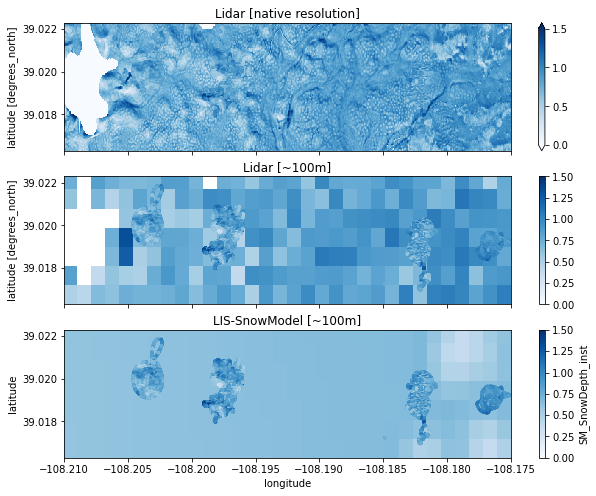

In [17]:
varbl = 'SM_SnowDepth_inst'
minval = 0
maxval = 1.5
mpr = 'Blues'
title_list = ['Lidar [native resolution]','Lidar [~100m]','LIS-SnowModel [~100m]']

fg,ax = plt.subplots(3,1,figsize=(10,8))
ax = np.ravel(ax)

ds_Lidar_reproj.plot(ax=ax[0],vmin=minval,vmax=maxval,cmap=mpr)
ds_Lidar_regrid.plot(ax=ax[1],vmin=minval,vmax=maxval,cmap=mpr)
ds_LIS[varbl].plot(ax=ax[2],vmin=minval,vmax=maxval,cmap=mpr)

df_Points_reproject = df_Points.to_crs(4326)

for axcount,axx in enumerate(ax):
    axx.scatter(df_Points_reproject.geometry.x,df_Points_reproject.geometry.y,4,df_Points_reproject.value/100,
              vmin=minval,vmax=maxval,cmap='Blues')
    axx.set_xlim(lon_range)
    axx.set_ylim(lat_range)
    axx.set_title(title_list[axcount])
    if axcount < 2:
        axx.set_xlabel('')
        axx.set_xticklabels('')


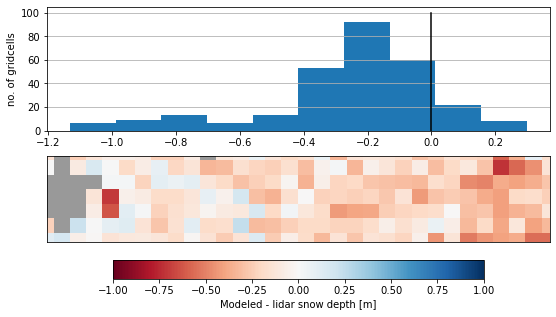

In [38]:
fg,ax = plt.subplots(2,1,figsize=(9,5))
ax = np.ravel(ax)
ext = [ds_Lidar_regrid.x.min().values-dx,ds_Lidar_regrid.x.max()+dx,
      ds_Lidar_regrid.y.max()+dy,ds_Lidar_regrid.y.min()-dy]
diff_spatial = ds_LIS[varbl].values-ds_Lidar_regrid.values

dat = ax[1].imshow(diff_spatial[0,:,:],extent=ext,cmap='RdBu',vmin=-1,vmax=1)
ax[1].set_xlim(lon_range)
ax[1].set_ylim(lat_range)
ax[1].set_facecolor([0.6,0.6,0.6])
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[0].set_ylabel('no. of gridcells')
ax[0].grid(axis='y')
ax[0].hist(np.ravel(diff_spatial))
ax[0].plot([0,0],[0,100],'-k')


cax = fg.colorbar(dat,orientation="horizontal",label='Modeled - lidar snow depth [m]')



In [42]:
# grab the data from each spatial set that overlaps each ground point measurement
x_indexer = xr.DataArray(df_Points_reproject.geometry.x,dims=["point"])
y_indexer = xr.DataArray(df_Points_reproject.geometry.y,dims=["point"])

ds_Lidar_reproj_vals = ds_Lidar_reproj.sel(x=x_indexer, y=y_indexer, method="nearest")
ds_Lidar_regrid_vals = ds_Lidar_regrid.sel(x=x_indexer, y=y_indexer, method="nearest")
ds_LIS_vals = ds_LIS[varbl].sel(longitude=x_indexer, latitude=y_indexer, method="nearest")

In [43]:
# save the differences data at points to the geodataframe
df_Points_reproject['diff_Lidar'] = np.ravel(ds_Lidar_reproj_vals.values)-(df_Points_reproject.value/100)
df_Points_reproject['diff_Lidar_regrid'] = np.ravel(ds_Lidar_regrid_vals.values)-(df_Points_reproject.value/100)
df_Points_reproject['diff_LIS'] = np.ravel(ds_LIS_vals.values)-(df_Points_reproject.value/100)

[Text(1, 0, 'native lidar - point'),
 Text(2, 0, 'regridded lidar - point'),
 Text(3, 0, 'LIS - point')]

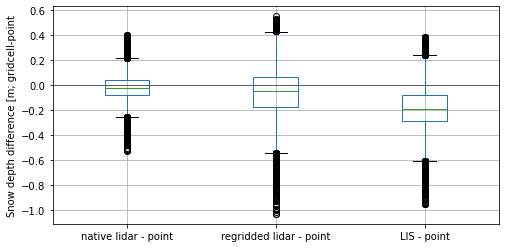

In [44]:
fg,ax = plt.subplots(figsize=(8,4))
ax.plot([0.5,3.5],[0,0],'-k',linewidth=0.5)
df_Points_reproject.boxplot(column=['diff_Lidar','diff_Lidar_regrid','diff_LIS'],ax=ax)
ax.set_ylabel('Snow depth difference [m; gridcell-point')

ax.set_xticklabels(['native lidar - point','regridded lidar - point','LIS - point'])

[[-108.21, 39.01629], [-108.175, 39.01629], [-108.175, 39.02229], [-108.21, 39.02229]]


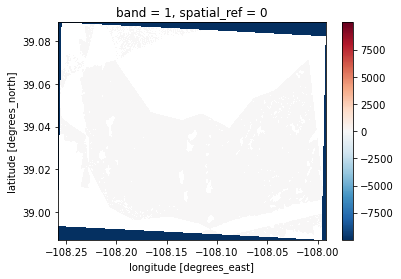

In [5]:
# this takes a little while because you can't filter the query by location (e.g. lat/lon??)
# ds_Lidar = dataIO_funcs.access_snowEx.access_layerData(b_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

ds_Lidar = rxr.open_rasterio('raster_depth.tif')
ds_Lidar_reproj = ds_Lidar.rio.reproject(4326)
ds_Lidar_reproj.plot()

# list of coordindate pairs
coordinates = [[ lon_range[0], lat_range[0] ], [ lon_range[1], lat_range[0] ], [ lon_range[1], lat_range[1]], [lon_range[0], lat_range[1]]]        
print(coordinates)
# Create a Shapely polygon from the coordinate-tuple list
ply_coord = Polygon(coordinates)
# create a dictionary with needed attributes and required geometry column
df = {'Attribute': ['name1'], 'geometry': ply_coord}
# Convert shapely object to a geodataframe 
poly = gpd.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326")

poly.geometry

# geodf = geopandas.read_file(...)
# xds = rioxarray.open_rasterio(...)
clipped = ds_Lidar_reproj.rio.clip(poly.geometry)


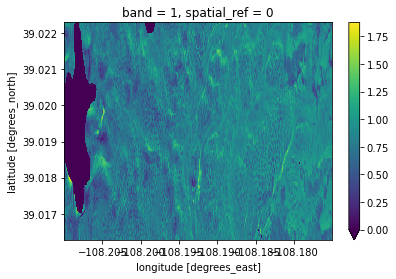

In [8]:
clipped.plot(vmin=0)

In [ ]:
# site_name = 'Grand Mesa'
# collection_date = date(2020, 2, 13)
# # Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff
# result = session.query(func.ST_AsTiff(gfunc.ST_Union(ImageData.raster, _type=Raster))).filter(SiteData.site_name == site_name).filter(ImageData.date == collection_date).filter(ImageData.instrument == 'lidar').filter(ImageData.type == 'depth')

/tmp/ipykernel_3936/483347798.py:1: SAWarning: SELECT statement has a cartesian product between FROM element(s) "public.points" and FROM element "public.layers".  Apply join condition(s) between each element to resolve.
  q.all()


In [ ]:
DO LIDAR DOWNLOAD HERE, SAVE THE LIDAR SO WE HAVE THIS AT THE SAME RESOLUTION AS WELL

In [ ]:
THEN, DO THE POINT DOWNLOAD HERE

In [ ]:
RUBBER MEETS THE ROAD! INTERACTIVE PLOT SHOWING THE 1) NATIVE-RES LIDAR, 2) REGRIDDED LIDAR
3) MODEL OUTPUT (EACH OF THOSE THREE HAVE THE FIELD CAMPAIGN OVER IT)

In [ ]:
USE VALERIE SCRIPT TO DO DATA COMPARISON!

(39.01629, 39.02229)

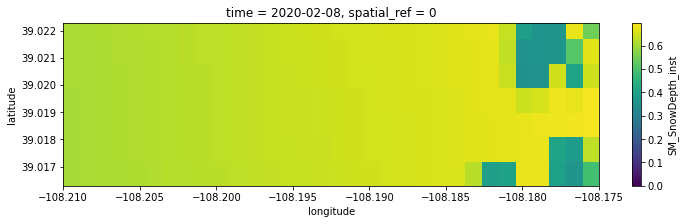

In [55]:
fg,ax = plt.subplots(figsize=(12,3))
ds_LIS['SM_SnowDepth_inst'].plot(ax=ax)
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

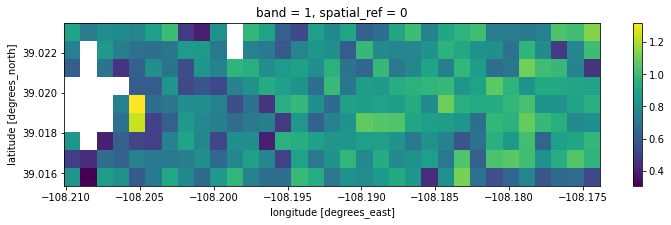

In [103]:
# show both comparisons (before/after reprojections)

import rioxarray as rxr
ds2 = rxr.open_rasterio('raster_depth.tif')
fg,ax = plt.subplots(figsize=(12,3))

outt = ds2.rio.reproject_match(ds_LIS)
outt.plot(ax=ax)
# (outt-ds_LIS['SM_SnowDepth_inst']).plot(ax=ax)

In [56]:
def date_between_prime_snowEx(start_date, end_date, folder_date):
    result = [folder_date[i] for i in range(len(folder_date)) if (folder_date[i].date >= start_date and folder_date[i].date <= end_date)]
    return result

In [106]:
# open the session
time_buffer_dy = 0
var_name = 'depth'

engine, session = get_db(db_name)

# do date filtering
pointDates = session.query(PointData.date).distinct().all()

time_sel_newForm = dateutil.parser.parse(time_sel)
start_date = time_sel_newForm-datetime.timedelta(days=time_buffer_dy)
start_date = start_date.date()
end_date = time_sel_newForm+datetime.timedelta(days=time_buffer_dy)
end_date = end_date.date()

filtered_dates = date_between_prime_snowEx(start_date, end_date, pointDates)

# query the dataset and concatenate
q = session.query(PointData).filter(PointData.type == var_name)   

data_day_list = []
for dt_count,dtt in enumerate(filtered_dates):
    print(dtt)
    dt_sel = datetime.date(dtt[0].year,dtt[0].month,dtt[0].day)
    q_sub = q.filter(PointData.date == dt_sel)
    df = query_to_geopandas(q_sub, engine)

    # i think this is what you do to concatenate??
    data_day_list.append(df)
df_concat = pd.concat(data_day_list)
df_concat_gpd = gpd.GeoDataFrame(df_concat)

session.close()

# list of coordindate pairs
coordinates = [[ lon_range[0], lat_range[0] ], [ lon_range[1], lat_range[0] ], [ lon_range[1], lat_range[1]], [lon_range[0], lat_range[1]]]        
print(coordinates)
# Create a Shapely polygon from the coordinate-tuple list
ply_coord = Polygon(coordinates)
# create a dictionary with needed attributes and required geometry column
df = {'Attribute': ['name1'], 'geometry': ply_coord}
# Convert shapely object to a geodataframe 
poly = gpd.GeoDataFrame(df, geometry='geometry', crs ="EPSG:4326").to_crs("EPSG:26912")
df_clipped = gpd.clip(df_concat_gpd, poly)

(datetime.date(2020, 2, 8),)
[[-108.21, 39.01629], [-108.175, 39.01629], [-108.175, 39.02229], [-108.21, 39.02229]]


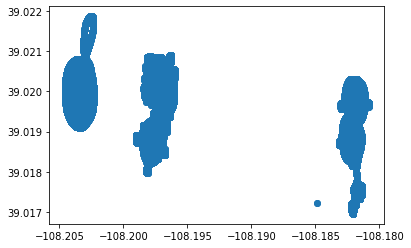

In [114]:
plt.scatter(df_clipped.longitude,df_clipped.latitude)

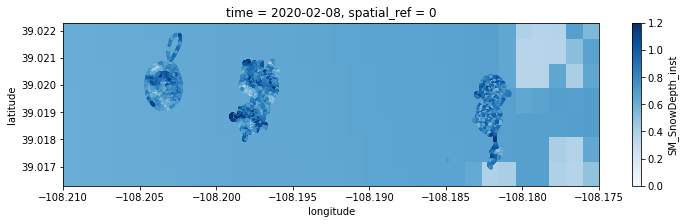

In [107]:
df_reproj = df_clipped.to_crs("EPSG:4326")
vvmin = 0
vvmax = 1.2

fg,ax = plt.subplots(figsize=(12,3))
out = ds_LIS['SM_SnowDepth_inst'].plot(vmin=vvmin,vmax=vvmax,
                                       cmap='Blues',ax=ax)
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

ax.scatter(df_reproj.geometry.x,df_reproj.geometry.y,4,df_reproj.value/100,
          vmin=vvmin,vmax=vvmax,cmap='Blues')



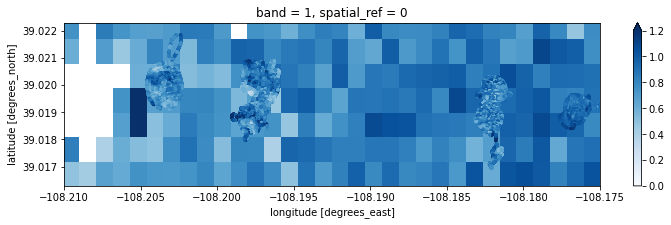

In [105]:
vvmin = 0
vvmax = 1.2

fg,ax = plt.subplots(figsize=(12,3))
outt.plot(vmin=vvmin,vmax=vvmax,cmap='Blues',ax=ax)
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

ax.scatter(df_reproj.geometry.x,df_reproj.geometry.y,4,df_reproj.value/100,
          vmin=vvmin,vmax=vvmax,cmap='Blues')

In [ ]:
df = dataIO_funcs.access_snowEx.access_pointData(db_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

# FOR PULLING SWESARR
#### TAKES A LOOK AT ALL OF THE DATA AVAILABLE, THEN ATTAEMPTS TO PULL THE DATA THAT IS 'TIME_BUFFER_DY' FROM THE SPECIFIED DAY 'TIME_SEL'

In [3]:
# pull the dates that SWESARR occurred
dataIO_funcs.access_SWESAR
SWESARR_names,SWESARR_dates = dataIO_funcs.access_SWESARR.get_url_paths(SWESARR_url)
print(SWESARR_names)

AttributeError: module 'dataIO_funcs' has no attribute 'access_SWESAR'

In [13]:
def date_between_prime(start_date, end_date, folder_date,folder_names):
    result = [folder_names[i] for i in range(len(folder_date)) if (folder_date[i] >= start_date and folder_date[i] <= end_date)]
    return result
time_sel_newForm = dateutil.parser.parse(time_sel)
start_date = time_sel_newForm-datetime.timedelta(days=time_buffer_dy)
end_date = time_sel_newForm+datetime.timedelta(days=time_buffer_dy)

final_files = date_between_prime(start_date, end_date, SWESARR_dates, SWESARR_names)
for flight_line in final_files:
    print(source_repo + flight_line)
    # command = wget -r -np -nH --reject "indexd.html*" -e robots=off -r --no-parent -A "*tif" source_repo + flight_line
    subprocess.Popen(['wget -r -np -nH --reject indexd.html* -e robots=off -r --no-parent -A *tif',source_repo+flight_line], shell=True)
    # ! wget -r -np -nH --reject "indexd.html*" -e robots=off -r --no-parent -A "*tif" source_repo + flight_line
    
data_files = []
os.chdir(os.getcwd() + flight_line)
for file in glob.glob("*.tif"):
    data_files.append(file)
    
data_files = [data for data in data_files if data[-8:] != '_dem.tif']

https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMCT2_13802_20006_012_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMCT2_31601_20006_011_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMNT1_09302_20006_009_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMNT1_09401_20006_005_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMST1_27302_20006_007_200210_225_XX_01/
https://glihtdata.gsfc.nasa.gov/files/radar/SWESARR/prerelease//GRMST1_27501_20006_003_200210_225_XX_01/


wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/model-eval/contributors/jupflug/GRMST1_27501_20006_003_200210_225_XX_01/'

# LIS MODEL READ-IN
#### READS IN THE DATA BASED ON THE LAT/LON/DATE CONSTRAINTS, PROVIDED THE MODEL VARIABLES OF FOCUS
#### WE ALSO GIVE IT THE APPROXIMATE MODEL DX AND DY WE WANT TO MOVE TO WHEN CONVERTING TO A RECTANGULAR GRID

In [3]:
ds_LIS = dataIO_funcs.access_LIS(lon_range,lat_range,time_sel,
                             model_variable,LIS_path,dx,dy,'bilinear')

In [3]:
ds_LIS

NameError: name 'ds_LIS' is not defined

# POINT AND LAYER DATA READ-IN

In [3]:
df = dataIO_funcs.access_snowEx.access_pointData(db_name,time_sel,time_buffer_dy,var_name,lat_range,lon_range)

(datetime.date(2020, 2, 8),)
(datetime.date(2020, 2, 9),)
(datetime.date(2020, 2, 6),)
(datetime.date(2020, 2, 10),)
(datetime.date(2020, 2, 7),)
[[-107.7, 38.8], [-107.5, 38.8], [-107.5, 38.9], [-107.7, 38.9]]


In [26]:
df

{'Attribute': ['name1'],
 'geometry': <shapely.geometry.polygon.Polygon at 0x7fa4e9abb550>}

In [24]:
engine, session = get_db(db_name)
pointDates = session.query(ImageData.date).distinct().all()


In [25]:
pointDates

[(None,),
 (datetime.date(2020, 2, 13),),
 (datetime.date(2020, 2, 21),),
 (datetime.date(2020, 2, 12),),
 (datetime.date(2020, 1, 31),),
 (datetime.date(2020, 2, 1),),
 (datetime.date(2020, 2, 2),),
 (datetime.date(2020, 3, 11),)]